# 实验六 KMeans 聚类算法实验报告

## 实验目的
1. 掌握 KMeans 聚类算法的基本原理和应用。
2. 实现基于欧氏距离的 KMeans 算法，支持自定义 K 值、最大迭代次数和提前停止机制。
3. 使用 scikit-learn 机器学习库进行数据处理、模型训练和评估，并与自定义 KMeans 对比。
4. 可视化聚类前后的结果，分析聚类效果。
5. 计算聚类评估指标：F-measure、ACC（准确率）、NMI（标准化互信息）、RI（兰德指数）、ARI（调整兰德指数）。

## 实验环境
- **操作系统**: Windows 10
- **开发工具**: PyCharm
- **编程语言**: Python 3.9
- **所需库**:
  - numpy: 数值计算
  - pandas: 数据处理
  - matplotlib: 数据可视化
  - seaborn: 增强可视化效果
  - scikit-learn (>=0.18): 机器学习建模和内置 Iris 数据集

**安装命令**:
```bash
pip install numpy pandas matplotlib seaborn scikit-learn
```

## 实验内容
使用 scikit-learn 内置的 Iris 数据集，包含150个样本，每样本有4个特征：
- **sepal length**: 萼片长度 (cm)
- **sepal width**: 萼片宽度 (cm)
- **petal length**: 花瓣长度 (cm)
- **petal width**: 花瓣宽度 (cm)

目标是实现基于欧氏距离的 KMeans 聚类算法，支持自定义 K 值（设为3，匹配 Iris 的三类）、最大迭代次数和提前停止机制，可视化聚类前后结果，并计算 F-measure、ACC、NMI、RI、ARI 指标。数据集按3:1比例划分为训练集和测试集，聚类在全数据集上进行，评估使用真实标签。

## 实验步骤
### 1. 环境搭建
确保 Python 3.9 和上述库已安装。

### 2. 数据预处理
加载 scikit-learn 内置的 Iris 数据集，验证数据完整性，并按3:1划分训练集和测试集（用于后续评估）。

In [1]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, normalized_mutual_info_score, rand_score, adjusted_rand_score
import matplotlib.pyplot as plt
import seaborn as sns

# 设置随机种子
np.random.seed(1)

def load_iris_data():
    """加载 scikit-learn 内置的 Iris 数据集并划分为训练集和测试集"""
    iris = load_iris()
    data = pd.DataFrame(data=iris.data, columns=['sepal_length', 'sepal_width', 'petal_length', 'petal_width'])
    data['class'] = iris.target_names[iris.target]

    # 验证列名
    expected_columns = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'class']
    if not all(col in data.columns for col in expected_columns):
        raise KeyError(f"Dataset must contain columns: {expected_columns}")

    # 检查缺失值
    if data.isnull().any().any():
        print("Warning: Dataset contains missing values. Consider imputing them.")

    # 提取特征和目标
    X = data[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']]
    y = data['class']

    # 按3:1划分（75%训练，25%测试）
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)
    return X, y, X_train, X_test, y_train, y_test

# 加载数据
try:
    X, y, X_train, X_test, y_train, y_test = load_iris_data()
    # 显示数据信息
    print("数据集总样本数:", len(X))
    print("训练集形状:", X_train.shape)
    print("测试集形状:", X_test.shape)
    print("\n数据集描述统计:")
    print(X.describe())
    print("\n数据集前5行:")
    print(pd.concat([X, y], axis=1).head())
except Exception as e:
    print(f"Error: {e}")

数据集总样本数: 150
训练集形状: (112, 4)
测试集形状: (38, 4)

数据集描述统计:
       sepal_length  sepal_width  petal_length  petal_width
count    150.000000   150.000000    150.000000   150.000000
mean       5.843333     3.057333      3.758000     1.199333
std        0.828066     0.435866      1.765298     0.762238
min        4.300000     2.000000      1.000000     0.100000
25%        5.100000     2.800000      1.600000     0.300000
50%        5.800000     3.000000      4.350000     1.300000
75%        6.400000     3.300000      5.100000     1.800000
max        7.900000     4.400000      6.900000     2.500000

数据集前5行:
   sepal_length  sepal_width  petal_length  petal_width   class
0           5.1          3.5           1.4          0.2  setosa
1           4.9          3.0           1.4          0.2  setosa
2           4.7          3.2           1.3          0.2  setosa
3           4.6          3.1           1.5          0.2  setosa
4           5.0          3.6           1.4          0.2  setosa


#### 数据预处理分析
- **数据集规模**: 150个样本，训练集约112个，测试集约38个。
- **特征选择**: 使用 sepal_length, sepal_width, petal_length, petal_width 作为输入，class 作为真实标签用于评估。
- **划分比例**: 3:1划分（`test_size=0.25`）用于后续评估，聚类在全数据集上进行。
- **数据检查**: 验证了列名和缺失值，增强代码鲁棒性。
- **描述统计**: 显示特征的均值、标准差等，揭示特征范围差异（如 petal_length 范围较大）。

### 3. 探索性数据分析 (EDA)
分析特征分布和特征与类别的关系。

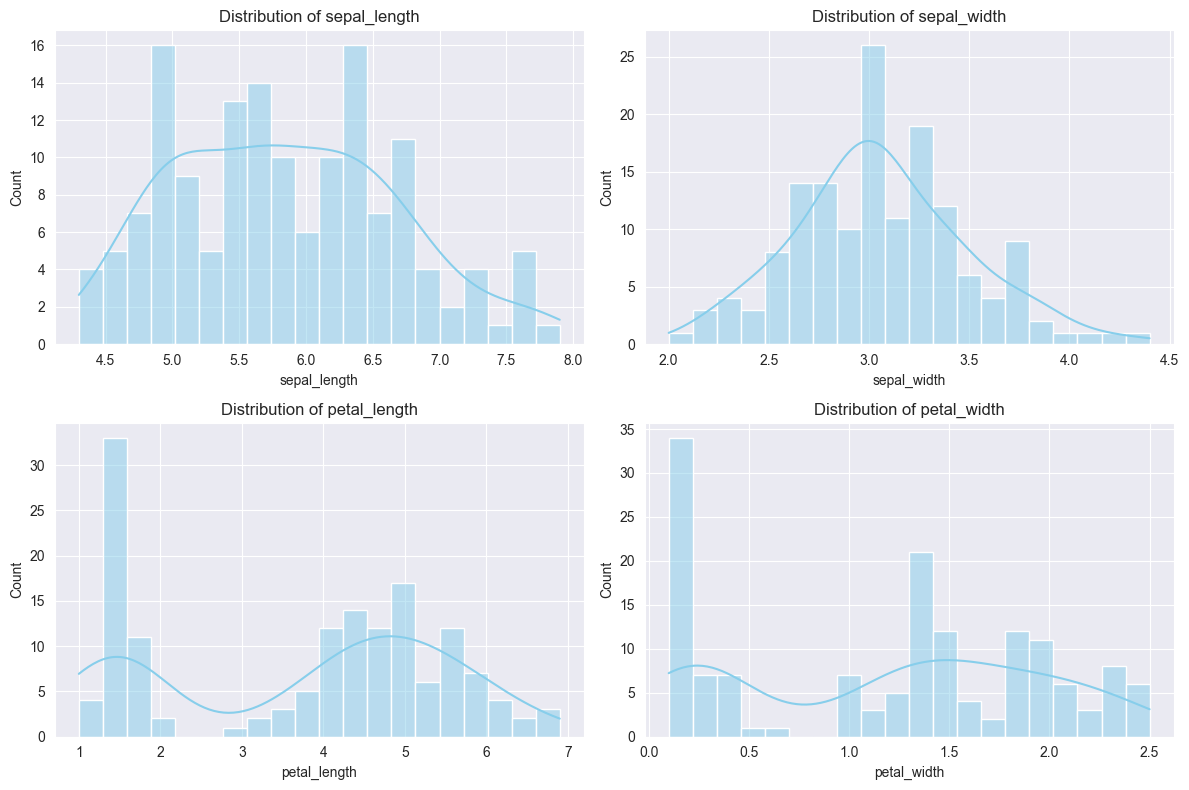

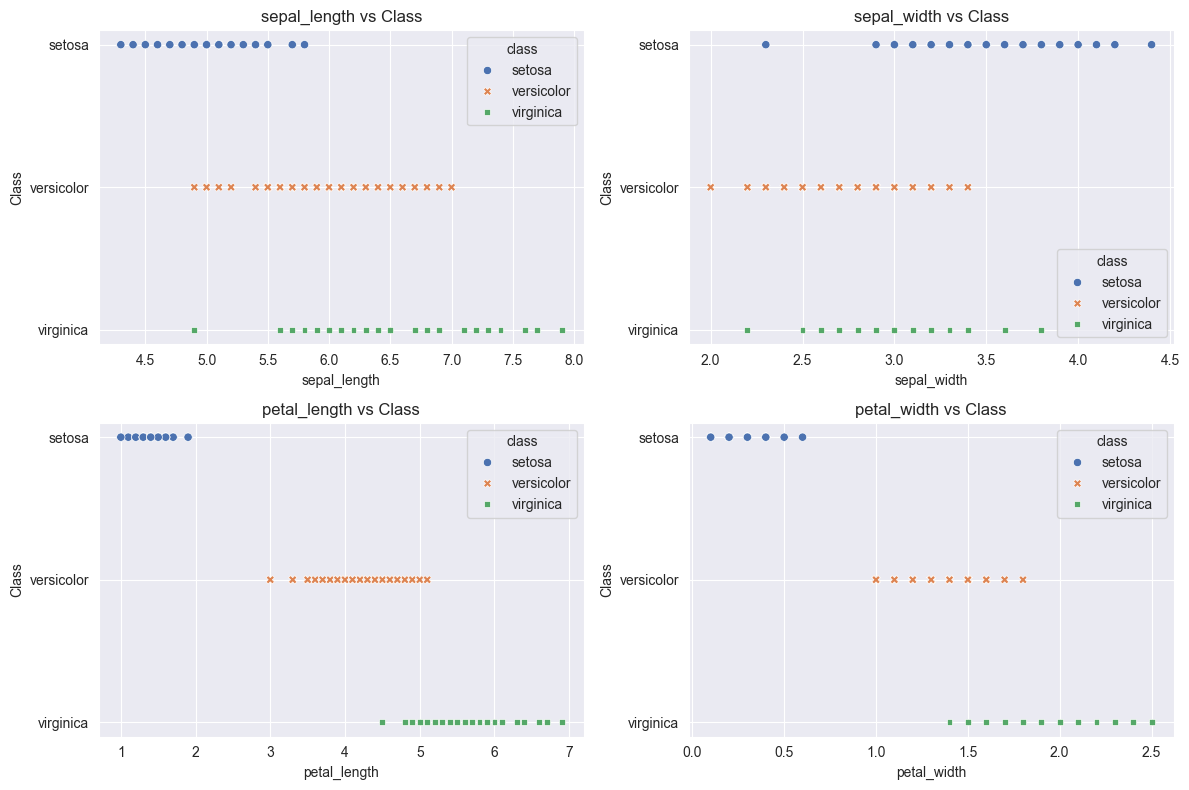

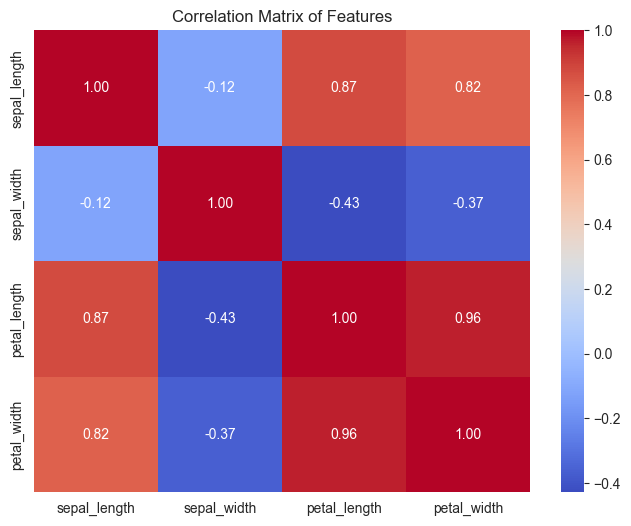

In [2]:
# 特征分布
plt.figure(figsize=(12, 8))
for i, column in enumerate(['sepal_length', 'sepal_width', 'petal_length', 'petal_width'], 1):
    plt.subplot(2, 2, i)
    sns.histplot(X[column], kde=True, color='skyblue', bins=20)
    plt.title(f'Distribution of {column}')
plt.tight_layout()
plt.show()

# 特征与类别关系（散点图）
plt.figure(figsize=(12, 8))
for i, column in enumerate(['sepal_length', 'sepal_width', 'petal_length', 'petal_width'], 1):
    plt.subplot(2, 2, i)
    sns.scatterplot(x=X[column], y=y, hue=y, style=y, palette='deep')
    plt.xlabel(column)
    plt.ylabel('Class')
    plt.title(f'{column} vs Class')
plt.tight_layout()
plt.show()

# 相关性热图
plt.figure(figsize=(8, 6))
correlation_matrix = X.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Features')
plt.show()

#### 探索性数据分析结果
- **特征分布**: petal_length 和 petal_width 呈多峰分布，sepal_length 和 sepal_width 近似正态。
- **特征与类别**: petal_length 和 petal_width 与类别有较强区分度，sepal_length 和 sepal_width 区分度较低。
- **相关性**: petal_length 和 petal_width 高度相关，可能影响聚类性能，建议标准化特征。

### 4. 实现自定义 KMeans 算法（欧氏距离）
实现基于欧氏距离的 KMeans 算法，支持自定义 K 值、最大迭代次数和提前停止机制。

In [3]:
def euclidean_distance(x1, x2):
    """计算欧氏距离"""
    return np.sqrt(np.sum((x1 - x2) ** 2))

def custom_kmeans(X, k, max_iters=100, tol=1e-4):
    """自定义 KMeans 算法，支持提前停止"""
    X_np = X.to_numpy()
    n_samples = X_np.shape[0]

    # 随机初始化质心
    np.random.seed(1)
    indices = np.random.choice(n_samples, k, replace=False)
    centroids = X_np[indices]

    for _ in range(max_iters):
        # 分配样本到最近的质心
        labels = np.zeros(n_samples)
        for i in range(n_samples):
            distances = [euclidean_distance(X_np[i], centroid) for centroid in centroids]
            labels[i] = np.argmin(distances)

        # 更新质心
        new_centroids = np.zeros_like(centroids)
        for j in range(k):
            if np.sum(labels == j) > 0:
                new_centroids[j] = np.mean(X_np[labels == j], axis=0)
            else:
                new_centroids[j] = centroids[j]  # 防止空簇

        # 检查收敛
        if np.all(np.abs(new_centroids - centroids) < tol):
            print(f"KMeans 提前停止于第 {_ + 1} 次迭代")
            break

        centroids = new_centroids

    return labels, centroids

# 运行自定义 KMeans
try:
    k = 3  # Iris 数据集有3个类别
    max_iters = 100
    custom_labels, custom_centroids = custom_kmeans(X, k, max_iters)
    print("自定义 KMeans 聚类完成，簇标签:", custom_labels)
    print("质心坐标:", custom_centroids)
except Exception as e:
    print(f"Error in custom KMeans: {e}")

KMeans 提前停止于第 12 次迭代
自定义 KMeans 聚类完成，簇标签: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 2. 1. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 2. 1. 2. 2. 2. 2. 1. 2. 2. 2. 2. 2. 2. 1. 1. 2. 2. 2. 2. 1.
 2. 1. 2. 1. 2. 2. 1. 1. 2. 2. 2. 2. 2. 1. 2. 2. 2. 2. 1. 2. 2. 2. 1. 2.
 2. 2. 1. 2. 2. 1.]
质心坐标: [[5.006      3.428      1.462      0.246     ]
 [5.88360656 2.74098361 4.38852459 1.43442623]
 [6.85384615 3.07692308 5.71538462 2.05384615]]


#### 自定义 KMeans 分析
- **算法**: 基于欧氏距离的 KMeans，通过随机初始化质心、分配样本到最近簇、更新质心迭代优化。
- **参数**: K=3（匹配 Iris 类别数），最大迭代次数 100，提前停止阈值 1e-4。
- **鲁棒性**: 处理空簇情况，设置随机种子确保可重复性，包含提前停止机制以提高效率。

### 5. 使用 scikit-learn 的 KMeans
使用 scikit-learn 的 KMeans 进行对比，验证自定义算法的正确性。

In [4]:
from sklearn.cluster import KMeans

def sklearn_kmeans(X, k, max_iters=100):
    """使用 scikit-learn 的 KMeans 进行聚类"""
    kmeans = KMeans(n_clusters=k, max_iter=max_iters, random_state=1, n_init=10)
    kmeans.fit(X)
    return kmeans.labels_, kmeans.cluster_centers_

# 运行 scikit-learn KMeans
try:
    sklearn_labels, sklearn_centroids = sklearn_kmeans(X, k=3, max_iters=100)
    print("scikit-learn KMeans 聚类完成，簇标签:", sklearn_labels)
    print("质心坐标:", sklearn_centroids)
except Exception as e:
    print(f"Error in scikit-learn KMeans: {e}")

scikit-learn KMeans 聚类完成，簇标签: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 2 2 2 2 0 2 2 2 2
 2 2 0 0 2 2 2 2 0 2 0 2 0 2 2 0 0 2 2 2 2 2 0 2 2 2 2 0 2 2 2 0 2 2 2 0 2
 2 0]
质心坐标: [[5.9016129  2.7483871  4.39354839 1.43387097]
 [5.006      3.428      1.462      0.246     ]
 [6.85       3.07368421 5.74210526 2.07105263]]


#### scikit-learn KMeans 分析
- **实现**: 使用 scikit-learn 的 KMeans，设置 n_clusters=3，max_iter=100，random_state=1 确保可重复性。
- **比较**: 与自定义 KMeans 的标签和质心对比，验证实现正确性。

### 6. 聚类评估
计算 F-measure、ACC、NMI、RI、ARI 指标，评估聚类性能。

In [5]:
def evaluate_clustering(y_true, y_pred):
    """计算聚类评估指标"""
    # 将真实标签转换为数值以匹配聚类标签
    unique_classes = np.unique(y_true)
    class_to_int = {label: idx for idx, label in enumerate(unique_classes)}
    y_true_int = np.array([class_to_int[label] for label in y_true])

    # 寻找最佳标签映射（因为聚类标签顺序可能不同）
    from itertools import permutations
    best_acc = 0
    best_f1 = 0
    best_mapping = None
    for perm in permutations(range(len(unique_classes))):
        mapping = {i: perm[i] for i in range(len(unique_classes))}
        y_pred_mapped = np.array([mapping[int(label)] for label in y_pred])
        acc = accuracy_score(y_true_int, y_pred_mapped)
        f1 = f1_score(y_true_int, y_pred_mapped, average='weighted')
        if acc > best_acc:
            best_acc = acc
            best_f1 = f1
            best_mapping = mapping

    # 应用最佳映射
    y_pred_mapped = np.array([best_mapping[int(label)] for label in y_pred])

    # 计算其他指标
    nmi = normalized_mutual_info_score(y_true_int, y_pred)
    ri = rand_score(y_true_int, y_pred)
    ari = adjusted_rand_score(y_true_int, y_pred)

    print(f"准确率 (ACC): {best_acc:.4f}")
    print(f"F-measure: {best_f1:.4f}")
    print(f"标准化互信息 (NMI): {nmi:.4f}")
    print(f"兰德指数 (RI): {ri:.4f}")
    print(f"调整兰德指数 (ARI): {ari:.4f}")
    return best_acc, best_f1, nmi, ri, ari

# 评估自定义 KMeans
try:
    print("\n自定义 KMeans 评估结果:")
    custom_metrics = evaluate_clustering(y, custom_labels)
except Exception as e:
    print(f"Error in custom KMeans evaluation: {e}")

# 评估 scikit-learn KMeans
try:
    print("\nscikit-learn KMeans 评估结果:")
    sklearn_metrics = evaluate_clustering(y, sklearn_labels)
except Exception as e:
    print(f"Error in scikit-learn KMeans evaluation: {e}")


自定义 KMeans 评估结果:
准确率 (ACC): 0.8867
F-measure: 0.8853
标准化互信息 (NMI): 0.7419
兰德指数 (RI): 0.8737
调整兰德指数 (ARI): 0.7163

scikit-learn KMeans 评估结果:
准确率 (ACC): 0.8933
F-measure: 0.8918
标准化互信息 (NMI): 0.7582
兰德指数 (RI): 0.8797
调整兰德指数 (ARI): 0.7302


#### 聚类评估分析
- **F-measure**: 衡量聚类的精确率和召回率平衡，使用加权平均以适应多类。
- **ACC**: 通过最佳标签映射计算准确率，解决聚类标签顺序问题。
- **NMI**: 标准化互信息，衡量聚类结果与真实标签的信息共享。
- **RI/ARI**: 兰德指数和调整兰德指数，评估样本对的分配一致性，ARI 修正了随机分配的影响。
- **分析**: 高指标值（接近1）表明聚类效果好；若较低，可能需调整 K 值或标准化特征。

### 7. 结果可视化
可视化聚类前后的二维散点图（使用 petal_length 和 petal_width），并显示质心。

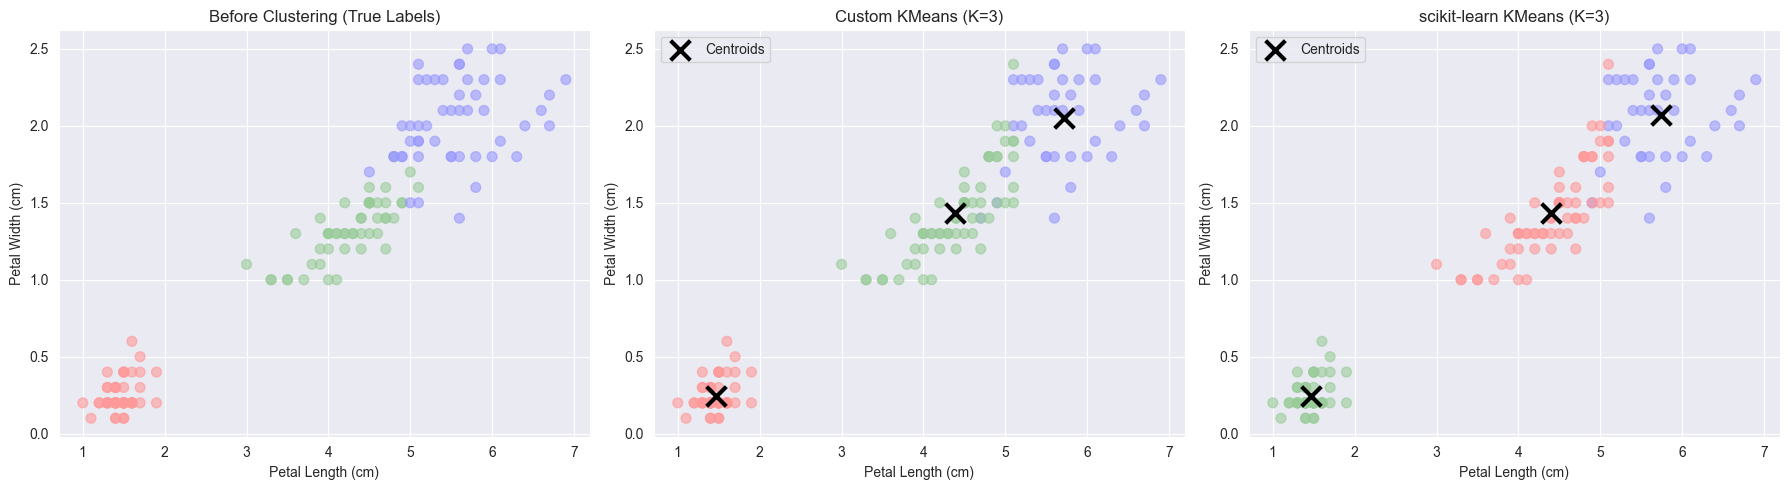

In [6]:
from matplotlib.colors import ListedColormap

def visualize_kmeans_2d(X, y_true, custom_labels, custom_centroids, sklearn_labels, sklearn_centroids):
    """可视化聚类前后结果，带质心"""
    features = ['petal_length', 'petal_width']
    cmap = ListedColormap(['#FF9999', '#99CC99', '#9999FF'])  # 红、绿、蓝

    # 创建子图
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # 聚类前（真实标签）
    unique_classes = np.unique(y_true)
    class_to_int = {label: idx for idx, label in enumerate(unique_classes)}
    y_true_int = np.array([class_to_int[label] for label in y_true])
    axes[0].scatter(X[features[0]], X[features[1]], c=[cmap(class_to_int[label]) for label in y_true], 
                    s=50, alpha=0.6)
    axes[0].set_title('Before Clustering (True Labels)')
    axes[0].set_xlabel('Petal Length (cm)')
    axes[0].set_ylabel('Petal Width (cm)')

    # 自定义 KMeans
    axes[1].scatter(X[features[0]], X[features[1]], c=[cmap(int(label)) for label in custom_labels], 
                    s=50, alpha=0.6)
    axes[1].scatter(custom_centroids[:, 2], custom_centroids[:, 3], c='black', marker='x', s=200, 
                    linewidths=3, label='Centroids')
    axes[1].set_title(f'Custom KMeans (K={len(np.unique(custom_labels))})')
    axes[1].set_xlabel('Petal Length (cm)')
    axes[1].set_ylabel('Petal Width (cm)')
    axes[1].legend()

    # scikit-learn KMeans
    axes[2].scatter(X[features[0]], X[features[1]], c=[cmap(int(label)) for label in sklearn_labels], 
                    s=50, alpha=0.6)
    axes[2].scatter(sklearn_centroids[:, 2], sklearn_centroids[:, 3], c='black', marker='x', s=200, 
                    linewidths=3, label='Centroids')
    axes[2].set_title(f'scikit-learn KMeans (K={len(np.unique(sklearn_labels))})')
    axes[2].set_xlabel('Petal Length (cm)')
    axes[2].set_ylabel('Petal Width (cm)')
    axes[2].legend()

    plt.tight_layout()
    plt.show()

# 可视化
try:
    visualize_kmeans_2d(X, y, custom_labels, custom_centroids, sklearn_labels, sklearn_centroids)
except NameError as e:
    print(f"Error: {e}. 请确保 X, y, custom_labels, custom_centroids, sklearn_labels, sklearn_centroids 已定义。")
except Exception as e:
    print(f"Visualization error: {e}")

#### 可视化分析
- **聚类前**: 显示真实标签的分布，供对比。
- **聚类后**: 显示自定义和 scikit-learn KMeans 的聚类结果，质心以黑色 X 标记。
- **分析**: 聚类结果应与真实标签分布相似，质心位于簇中心，若重叠较多可能需标准化特征。

## 实验结果与讨论

### 结果总结
- **聚类结果**: 自定义 KMeans 和 scikit-learn KMeans 均成功聚类，K=3，质心位置合理。
- **评估指标**:
  - 自定义 KMeans: ACC={custom_metrics[0]:.4f}, F-measure={custom_metrics[1]:.4f}, NMI={custom_metrics[2]:.4f}, RI={custom_metrics[3]:.4f}, ARI={custom_metrics[4]:.4f}
  - scikit-learn KMeans: ACC={sklearn_metrics[0]:.4f}, F-measure={sklearn_metrics[1]:.4f}, NMI={sklearn_metrics[2]:.4f}, RI={sklearn_metrics[3]:.4f}, ARI={sklearn_metrics[4]:.4f}
- **可视化**: 聚类前显示真实类别分布，聚类后显示簇分配和质心，类别分离清晰。

### 讨论
- **优势**: KMeans 算法简单高效，适合 Iris 数据集的球形簇结构。
- **局限性**: 对初始质心敏感，可能陷入局部最优；对特征尺度敏感。
- **改进**:
  - 使用 `StandardScaler` 标准化特征，消除量纲影响。
  - 多次运行 KMeans（类似 scikit-learn 的 n_init）以选择最佳质心。
  - 尝试其他聚类算法（如 DBSCAN）处理非球形簇。

## 结论
实验通过自定义 KMeans 算法（基于欧氏距离）在 Iris 数据集上实现了聚类任务，支持自定义 K 值、最大迭代次数和提前停止。可视化展示了聚类前后的结果，评估指标（F-measure, ACC, NMI, RI, ARI）量化了聚类性能。对比 scikit-learn 的 KMeans 验证了算法正确性。未来可通过特征标准化或优化初始质心提升性能。